# LSST Microlens Rate #

**2016-05-18 (WIC)** - Attempt to find a version of Poleski (2016 MNRAS) appropriate for LSST.

## Motivation ##

Poleski (2016 MNRAS, hereafter P16) has a nice empirical relation for the specific microlensing rate (per square degrees per year) for stellar events with timescale > 8d. This takes the broad form
\begin{equation}
    \gamma \sim N^{\alpha}_{lens} N_{src}
\end{equation}
where $N_{lens}$ is the surface density of possible lenses, $N_{src}$ the surface density of possible background sources, and $\alpha$ a parameter fit from the OGLE-III catalog.

P16 use the following parameterization: 

* $N_{src}$ = $N_{\ast}(I < I_{max})$, the number density of stars down to the OGLE-III completeness limit. 
* $N_{lens}$ = $N_{RC}$, the number of Red Clump giants measured by OGLE-III, which was essentially complete to red clump giants.

For LSST we don't know $N_{RC}$, and are observing well outside the bulge in some fields. However a reasonable approach would be to parameterize $N_{lens} \approx N_{\ast}(I < 27)$ - i.e. the number density of potential lenses down to some deep limit - and plot against the P16 OGLE-III rates to calibrate the normalization. That is what is done here.

## Setup ##

On my system sims_maf_contrib doesn't play nice with the system. Since healpyUtils.py will be needed, ensure they are present. I have the following in my working directory:
* healpyUtils.py
* event_rates_CDS.dat
* OpSim outputs in .db format

Or, pre-computed density outputs might be stored somewhere. I have starMap_test

In [1]:
! ls -l healpy*py
! ls -l event_rates_*dat
! ls -l *db
! ls -l | grep starMap_test

-rw-r--r--  1 clarkson  staff  4606 Apr 23 12:12 healpyUtils.py
-rw-r--r--  1 clarkson  staff  120717 May 17 17:58 event_rates_CDS.dat
-rw-r--r--  1 clarkson  staff  4833732608 Apr 22 20:11 astro_lsst_01_1004_sqlite.db
-rw-r--r--  1 clarkson  staff  4906594304 Jan  4 00:15 minion_1016_sqlite.db
-rw-r--r--  1 clarkson  staff  4933367808 Jan  6 14:39 minion_1020_sqlite.db
drwxr-xr-x   52 clarkson  staff        1768 May 18 19:35 starMap_test


Also need to ensure that sims_maps is set up (using gitLFS to take down the actual catalogs) as well as sims_maf.

**Needed modules and methods**

In [2]:
import os, time

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.maps as maps

In [4]:
# To create new bundle from the pre-loaded ones
import copy

In [5]:
# To load P16 data
from astropy.io import ascii

In [6]:
# handy for display
from matplotlib.colors import LogNorm

In [7]:
# Needed for spatial coords
import numpy as np
import healpy as hp
import healpyUtils
from astropy.coordinates import SkyCoord

In [8]:
# Loading pre-ran metric results
import lsst.sims.maf.metricBundles as mb

### Choices ###

In [9]:
# filenames for density metrics
buildDensities = False
filDensLens = 'opsim_iMag_lt_27_5_night_lt_1095_HEAL.npz'
filDensSrc = 'opsim_iMag_lt_20_5_night_lt_1095_HEAL.npz'

In [10]:
# control variables
dirMetrics = 'starMap_test'

# opsimdb with chosen strategy
opsimrun = 'minion_1016_sqlite.db'

# magnitude limits for lens and source
magFaintLens = 27.5
magFaintSrc = 20.5
filtLens = 'i'
filtSrc = 'i'
tMax = 365.25 * 3.

## Obtain $N_{lens}$ and $N_{src}$

In [11]:
opsdb = db.OpsimDatabase(opsimrun)
resultsDb = db.ResultsDb(outDir=dirMetrics)

In [12]:
bundleList = []
sql = 'night < %i' % (tMax) # See How well we do after year 3
slicer = slicers.HealpixSlicer(nside=64, useCache=False)

# Metrics
metricLens = metrics.StarDensityMetric(rmagLimit=magFaintLens, \
                                   metricName='%sMag < %.1f' % (filtLens, magFaintLens))

metricSrc = metrics.StarDensityMetric(rmagLimit=magFaintSrc, \
                                      metricName='%sMag < %.1f' % (filtSrc, magFaintSrc))

# Maps
mafMapLens = maps.StellarDensityMap(filtername=filtLens[:])
mafMapSrc = maps.StellarDensityMap(filtername=filtSrc[:])

plotDict = {'colorMin':0.001, 'colorMax':.1, 'logScale':True}

# Assemble the bundle from the metrics
bundle = metricBundles.MetricBundle(metricLens,\
                                    slicer,sql, \
                                    mapsList=[mafMapSrc], \
                                    plotDict=plotDict)
bundleList.append(bundle)
bundle = metricBundles.MetricBundle(metricSrc, \
                                    slicer,sql, \
                                    mapsList=[mafMapSrc], \
                                    plotDict=plotDict)
bundleList.append(bundle)
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [13]:
hasLens =  os.access('%s/%s' % (dirMetrics, filDensLens), os.R_OK)
hasSrc =  os.access('%s/%s' % (dirMetrics, filDensSrc), os.R_OK)

In [14]:
if not hasLens or not hasSrc or buildDensities:
    bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, \
                                             outDir=dirMetrics, \
                                             resultsDb=resultsDb)
    bgroup.runAll()
    bgroup.plotAll(closefigs=False)
else:
    print "filSrc and filLens already present. Not rebuilding."

filSrc and filLens already present. Not rebuilding.


## Load the LSST and OGLE datasets ##

### LSST - "lenses" and "sources" ###

In [15]:
# However we obtained it, load the bundle for lenses. 
pathLens = '%s/%s' % (dirMetrics, filDensLens)
myBundle = mb.createEmptyMetricBundle()
myBundle.read(pathLens)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [16]:
# Import the bundle for sources
pathSrc = '%s/%s' % (dirMetrics, filDensSrc)
srcBundle = mb.createEmptyMetricBundle()
srcBundle.read(pathSrc)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


### OGLE - P16 Table 2 ###

In [17]:
r = ascii.get_reader(ascii.Cds)
tIn = r.read('event_rates_CDS.dat')

In [18]:
print tIn.colnames

['Name', 'l', 'b', 'N_RC', 'N_*(I<20)', 'N_*(I<20.5)', 'gam_1,20', 'gam_0.55,20.5']


## Find field centers for LSST estimates in galactic coords ##

In [19]:
# Get the HEALPIX centers
npix = myBundle.metricValues.size
nside = hp.npix2nside(npix)
ra, dec = healpyUtils.hpid2RaDec(nside, np.arange(npix))
cc = SkyCoord(ra=np.copy(ra), dec=np.copy(dec), frame='fk5', unit='deg')

In [20]:
# some minor adjustments to do here... Set up convenience views:
gL = np.copy(cc.galactic.l)
gB = np.copy(cc.galactic.b)

bHi = gL > 180.
gL[bHi] -= 360.

## Plot up the two datasets ##

(15.0, -15.0)

/Users/clarkson/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


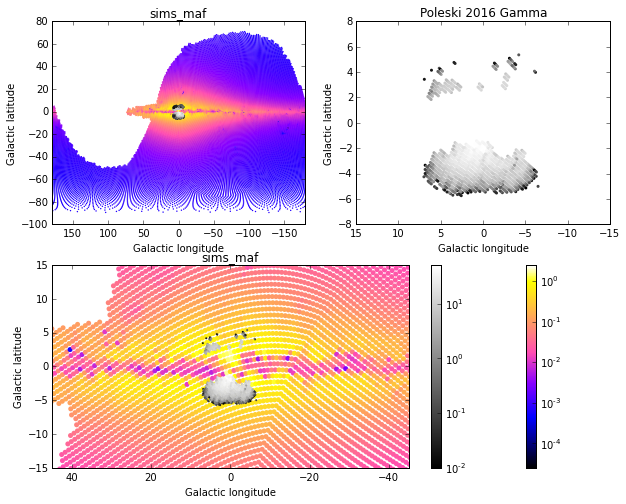

In [21]:
cMap = plt.cm.get_cmap('gnuplot2')
plt.figure(2, figsize=(10,8))
plt.clf()
plt.subplot(221)
plt.scatter(gL, gB, \
            c=myBundle.metricValues, edgecolor='none', s=2, \
           cmap=cMap, norm=LogNorm())
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
plt.title('sims_maf')
plt.xlim(180., -180.)

# overplot the Poleski et al. points
plt.scatter(tIn['l'], tIn['b'], \
            c=tIn['gam_0.55,20.5'], \
            edgecolor='none', s=9, \
           cmap=plt.cm.get_cmap('gray'), \
            norm=LogNorm())

plt.subplot(212)
plt.scatter(gL, gB, \
            c=myBundle.metricValues, edgecolor='none', \
            s=25, \
           cmap=cMap, norm=LogNorm())
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
plt.title('sims_maf')
plt.colorbar()

# overplot the Poleski et al. points
plt.scatter(tIn['l'], tIn['b'], \
            c=tIn['gam_0.55,20.5'], \
            edgecolor='none', s=4, \
           cmap=plt.cm.get_cmap('gray'), \
            norm=LogNorm())
plt.colorbar()

plt.xlim(45., -45.)
plt.ylim(-15., 15.)


plt.subplot(222)
plt.scatter(tIn['l'], tIn['b'], \
            c=tIn['gam_0.55,20.5'], \
            edgecolor='none', s=9, \
           cmap=plt.cm.get_cmap('gray'), \
            norm=LogNorm())
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
plt.title('Poleski 2016 Gamma')
plt.xlim(15., -15.)

## Naiive cross-match spatially ##

In [22]:
# Looks like LSST less spatially-sampled, so cut down on that first
loL = np.min(tIn['l'])-0.1
hiL = np.max(tIn['l'])+0.1
loB = np.min(tIn['b'])-0.1
hiB = np.max(tIn['b'])+0.1
bReg = (gL >= loL) & (gL < hiL) & (gB >= loB) & (gB < hiB) 
gReg = np.where(bReg)[0]

In [23]:
# select OGLE-III fields for above minimum event rate
rateMin = 0.2  # two per HEALPIX per decade
bOGLE = (tIn['gam_0.55,20.5'] > rateMin)

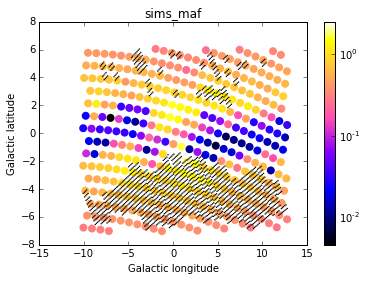

In [24]:
plt.figure(3, figsize=(6,4))
plt.clf()
plt.scatter(gL[bReg], gB[bReg], \
            c=myBundle.metricValues[bReg], edgecolor='none', \
            s=64, \
           cmap=cMap, norm=LogNorm())
plt.xlabel('Galactic longitude')
plt.ylabel('Galactic latitude')
plt.title('sims_maf')
plt.colorbar()

plt.scatter(tIn['l'], tIn['b'], \
            c='k', \
            edgecolor='none', s=2, \
           cmap=plt.cm.get_cmap('gray'), \
            norm=LogNorm())

Minimum distance... From Slicer:
"Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes"

In [25]:
def naiiveMatch(x1, y1, x2, y2, dMin=0.5):
    
    """Quick and rough matching between two sets of coordinates. Returns matching indices."""
    
    n1 = np.size(x1)
    n2 = np.size(x2)
    
    # arrays of matches
    l1 = []
    l2 = []
        
    for i1 in range(n1):
        xc = np.float(x1[i1])
        yc = np.float(y1[i1])
        d2 = np.sqrt( (x2 - xc)**2 + (y2 - yc)**2)
        if np.min(d2) > dMin:
            continue
        
        l1.append(i1)
        l2.append(np.argmin(d2))
    
    return np.asarray(l1, 'int'), np.asarray(l2, 'int')

In [26]:
# find the nearest matches
gLSST, gOGLE = naiiveMatch(gL[bReg], gB[bReg], tIn['l'][bOGLE], tIn['b'][bOGLE])

In [27]:
gReg = np.where(bReg)[0]
gNonzer = np.where(bOGLE)[0]

# Get the indices we'll actually need
gSims = gReg[gLSST]
gObs = gNonzer[gOGLE]

## What do the P16 data look like? ##

P16 does not include the actual microlensing rates observed by OGLE, but instead the predictions for $\gamma$. So let's take a look at that parameter...

In [28]:
sens = tIn['N_RC']**0.55 * tIn['N_*(I<20.5)']

In [29]:
# Examining the plots of P16 below, it seems clear a different relationship
# is needed for low-rate regions. The gray polygon in the lower-right panel 
# in the figure below has the following vertices, which we use for our selection
# box.
yPoly = [1e-3, 1., 1., 1e-3]
xPoly = [15, 15, 20, 20]

In [30]:
bPoly = (sens > np.min(xPoly)) \
    & (sens < np.max(xPoly)) & \
    (tIn['gam_0.55,20.5'] >= np.min(yPoly)) & \
    (tIn['gam_0.55,20.5'] < np.max(yPoly))
gPoly = np.where(bPoly)[0]

In [31]:
# try fitting power law to this...
logSens = np.log10(sens)
logGamm = np.log10(np.abs(tIn['gam_0.55,20.5']))
parsPow = np.polyfit(logSens[gPoly], logGamm[gPoly], 1)
print parsPow

[ 19.132256   -24.98647739]


/Users/clarkson/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


In [32]:
# define a new feature to return P16 gamma given sensitivity
def returnGammaFromSens(x, parsPow=[19.13, -24.99], parsLine=[0.767, -14.6], \
                       hiLim=20., loLim=12.):
    
    """Returns P16 gamma given sensitivity"""
    
    bHi = x >= hiLim
    bLo = x < loLim
    bMed = (~bHi) & (~bLo)
    
    yRet = np.zeros(np.size(x))
    yRet[bHi]  = parsLine[0] * x[bHi] + parsLine[1]
    yRet[bMed] = 10.0**parsPow[1] * x[bMed]**parsPow[0]
    yRet[bLo] = np.min(yRet[bMed]) # enforce smoothness
    
    return yRet

(0, 60)

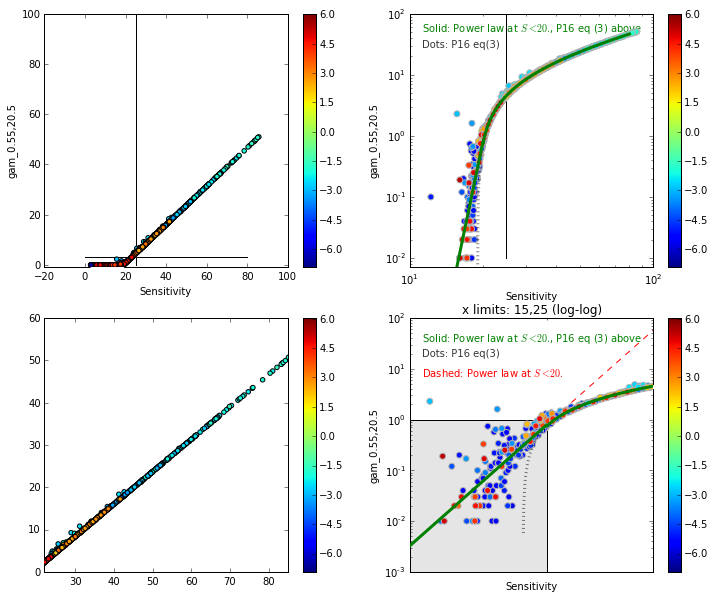

In [33]:
plt.figure(figsize=(12,10))
plt.clf()

# annotation string for green stitched-together curves
sStitch = r'Solid: Power law at $S < 20.$, P16 eq (3) above'
sPower = r'Dashed: Power law at $S < 20.$'
sLine = r'Dots: P16 eq(3)'


plt.subplot(221)
plt.plot(sens, tIn['gam_0.55,20.5'], 'w.', zorder=5)
plt.scatter(sens, tIn['gam_0.55,20.5'], c=tIn['b'], zorder=15)
plt.colorbar()
plt.ylim(-1,1e2)
plt.xlabel('Sensitivity')
plt.ylabel('gam_0.55,20.5')

# approximate limits for Poleski 16 Figure 4
plt.plot([25., 25.], [1e-2, 1e2], 'k-')
plt.plot([0.,80.], [3., 3.], 'k-')

plt.subplot(222)
plt.loglog(sens, tIn['gam_0.55,20.5'], 'w.', zorder=5)
plt.scatter(sens, tIn['gam_0.55,20.5'], c=tIn['b'], zorder=15, \
           s=36, edgecolor='0.7')
plt.colorbar()
plt.ylim(7e-3,1e2)
plt.xlim(10,100)
plt.xlabel('Sensitivity')
plt.ylabel('gam_0.55,20.5')

# approximate limits for Poleski 16 Figure 4
plt.plot([25., 25.], [1e-2, 1e2], 'k-')
plt.plot([0.,100.], [3., 3.], 'k-')

# generate linspace of Sensitivity values
sFine = np.linspace(5, 80, 5000, endpoint=True)
gamFine = 0.767 * sFine - 14.6
plt.plot(sFine, gamFine, zorder=25, lw=3, alpha=0.5, color='k', ls=":")

# Try plotting our stitched together model
yStitch = returnGammaFromSens(sFine)
plt.plot(sFine, yStitch, 'g-', lw=3, zorder=25)

# Annotate with the graphs
plt.annotate(sStitch, (0.05,0.97), xycoords='axes fraction', \
            ha='left', va='top', color='g')
plt.annotate(sLine, (0.05,0.90), xycoords='axes fraction', \
            ha='left', va='top', color='0.2')

#### zoom into the low-N region
plt.subplot(224)
plt.loglog(sens, tIn['gam_0.55,20.5'], 'w.', zorder=5)
plt.scatter(sens, tIn['gam_0.55,20.5'], c=tIn['b'], zorder=15, \
           s=36, edgecolor='0.7')
plt.colorbar()
#plt.ylim(-5,10)
plt.xlim(15,25)
plt.xlabel('Sensitivity')
plt.ylabel('gam_0.55,20.5')
plt.plot(sFine, gamFine, zorder=25, lw=3, alpha=0.5, color='k', ls=":")
plt.title('x limits: 15,25 (log-log)')

plt.plot([20., 20.], [1e-3,1.], color='k')
plt.plot([15., 20.], [1.,1.], color='k')
yPoly = [1e-3, 1., 1., 1e-3]
xPoly = [15, 15, 20, 20]
plt.fill(xPoly, yPoly, alpha=0.2, zorder=2, color='0.5')

# Try overplotting that power law
# plt.plot(sFine, 10.0**parsPow[1]*sFine**parsPow[0], 'r--')

# Try overplotting that power law
ssFine = np.linspace(15,25,500)
plt.plot(ssFine, 10.0**parsPow[1]*ssFine**parsPow[0], 'r--')
yStitch2 = returnGammaFromSens(ssFine)
plt.plot(ssFine, yStitch2, 'g-', lw=3, zorder=25)

plt.annotate(sStitch, (0.05,0.95), xycoords='axes fraction', \
            ha='left', va='top', color='g')
plt.annotate(sPower, (0.05,0.81), xycoords='axes fraction', \
            ha='left', va='top', color='r')
plt.annotate(sLine, (0.05,0.88), xycoords='axes fraction', \
            ha='left', va='top', color='0.2')



# Try reproducing P16 F4 left panel
plt.subplot(223)
plt.scatter(sens, tIn['gam_0.55,20.5'], c=tIn['b'], zorder=15)
plt.colorbar()
plt.xlim(22,85)
plt.ylim(0, 60)



Notice from the bottom-right panel that **equation (3) of P16 *substantially* underpredicts the lensing rate recorded in their Table 2**. It is possible I have misunderstood what P16 were doing (particularly in the work leading to their Figure 6), but I am satisfied that the green hybrid model at least reproduces their published lensing rate predictions with a higher dynamic range than just the straight-line fit (3).

To allow high dynamic range (for a comparison from LSST to OGLE-III), the hybrid model (the green line above) should be used. From P16 Figure 6, my impression is that the smoothly tapered (i.e. hybrid) model is the one that best represents the OGLE-III observed rates as well.

So I use the green hybrid model near the bottom when estimating the LSST-predicted microlensing rate. It's straightforward to comment it out and return to pure P16 eq (3) in that cell.

12.5892541179


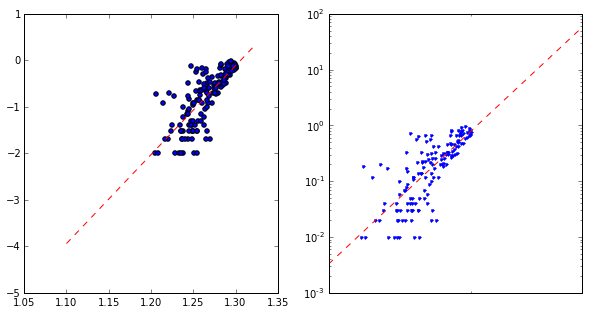

In [34]:
# Examine the low-sensitivity tail in particular...
plt.figure(figsize=(10,5))
plt.clf()

#plt.(logSens[gPoly], logGamm[gPoly], 'w.', zorder=1)
plt.subplot(121)
plt.scatter(logSens[gPoly], logGamm[gPoly])
ssFine = np.linspace(1.10, 1.32)
plt.plot(ssFine, np.polyval(parsPow, ssFine), 'r--')

plt.subplot(122)
plt.loglog(sens[gPoly], tIn['gam_0.55,20.5'][gPoly], 'b.')
dd = np.linspace(15., 25., 500)
plt.plot(dd, 10.0**parsPow[1] * dd**parsPow[0], 'r--')
plt.xlim(15,25)

print 10.0**1.10

**Summary:** 
* It looks like P16 set a hard floor at $\gamma = 0.$ So we should also only use fields for which $\gamma_{0.55, 20.5} > 0.$
* The relationship seems to change character for $S_{0.55,20.5} \lesssim 20.$ (or for $\gamma_{0.55,20} \lesssim 1.$ Below that level the relationships shown in P16 do not accurately represent their $\gamma_{0.55,0.25}$.
* It looks like P16 are switching to a power law for $S_{0.55,20.5} \lesssim 20$.

We should not expect $\gamma_{OGLE} \approx \gamma_{LSST}$ where $\gamma_{0.55,0.25} \lesssim 1.0$, so use that as a lower selection bound.

## How well does $N_{\ast}$ track P16's $N_{RC}$? ##

Try fitting two ways: straight line fit (np.polyfit will do fine here), and the "Golden Rule" of pattern scaling (to force the relationship through (0,0):
\begin{eqnarray}
    f & \equiv & \frac{N_{RC}}{N_{LSST}} \\
    & & \\
    \langle f \rangle  & = & \frac{\sum_i N_{RC, i}~N_{LSST, i}} {\sum_i N^2_{LSST, i} }
\end{eqnarray}

Tried this first with all the data, then selecting on a subset by galactic latitude (|b| > 2.5), since the density-density plots below suggest low-latitude fields are quite discrepant in the model (and might follow a different relationship). It's pretty egregious to throw away data like this, but improvements of LSST's density model are outside the scope of this quick investigation!

In [35]:
# try fitting N_{RC} as a function of N_{LSST}
parsDens = np.polyfit(myBundle.metricValues[gSims], tIn['N_RC'][gObs], 1)
print parsDens

[ 42.63283371  12.32862343]


In [36]:
# try fitting only for moderate galactic latitude
bClose = 2.5
bModerate = np.abs(tIn['b'][gObs]) > bClose 
gModerate = np.where(bModerate)[0]
gOutly = np.where(~bModerate)[0]
#gModerate = np.where(np.abs(tIn['b'][gObs]) > bClose )[0]
parsDensMod = np.polyfit(myBundle.metricValues[gSims][gModerate], \
                         tIn['N_RC'][gObs][gModerate], \
                         1)
print parsDensMod
print np.size(gModerate), np.size(gSims)

[ 50.08906492   0.73662056]
68 85


In [37]:
# Try fitting the outliers
parsLensOutly = np.polyfit(myBundle.metricValues[gSims][gOutly], \
                         tIn['N_RC'][gObs][gOutly], \
                         1)
print parsLensOutly

[ 28.93341479  47.90035298]


In [38]:
# try a golden-rule scaling
nStars = myBundle.metricValues[gSims][gModerate]
nRC = tIn['N_RC'][gObs][gModerate]
fLens = np.sum(nStars * nRC) / np.sum(nStars**2)
print fLens

50.883460129


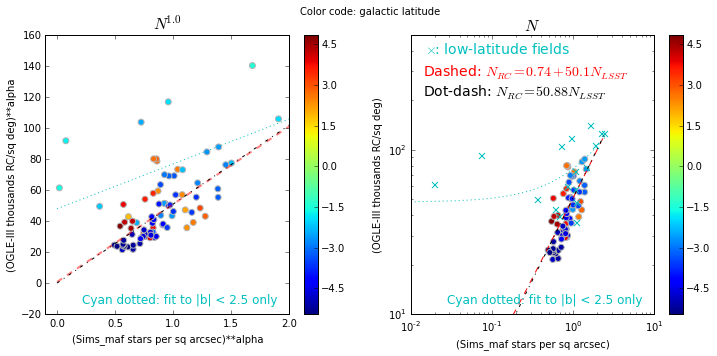

In [39]:
# let's try a straight scatterplot of the LSST density 
# vs the P16 R16 density...
plt.figure(4, figsize=(12,5))
plt.clf()

sAnno = r'Dashed: $N_{RC} = %.2f + %.1f N_{LSST}$' % (parsDensMod[1], parsDensMod[0])
sLens = r'Dot-dash: $N_{RC} = %.2f N_{LSST}$' % (fLens)
sOutly = 'Cyan dotted: fit to |b| < %.1f only' % (bClose)

# Setting alphaSho != 1 shows the component in the P16 "sensitivity" relation.
#alphaSho=0.55
alphaSho=1.

# what happens if we use our straight-line fit to N_RC from N_LSST?
xFine = np.linspace(0.0001, 2.5, 100, endpoint=True)
yFine = np.polyval(parsDensMod, xFine)
yOutly = np.polyval(parsLensOutly, xFine)


plt.subplot(121)
plt.scatter(myBundle.metricValues[gSims]**alphaSho, \
            tIn['N_RC'][gObs]**alphaSho, \
           c=tIn['b'][gObs], \
            edgecolor='0.7', s=36)
plt.xlabel('(Sims_maf stars per sq arcsec)**alpha')
plt.ylabel('(OGLE-III thousands RC/sq deg)**alpha')
plt.colorbar()

plt.xlim(-0.1,  2.0)
#plt.ylim(0., 20.0)

# Can we just scale N_LSST to N_RC??
#plt.plot(xFine, scaleDens**0.5*xFine, 'r--', lw=2, alpha=0.5)
plt.plot(xFine**alphaSho, yFine**alphaSho, 'r--', lw=2, alpha=0.5)
plt.plot(xFine**alphaSho, (fLens * xFine)**alphaSho, 'k-.')
plt.plot(xFine**alphaSho, yOutly**alphaSho, color='c', ls=':')




plt.title(r'$N^{%.1f}$' % (alphaSho), fontsize=16)

#plt.annotate(sAnno, \
#            (0.99, 0.15), ha='right', va='bottom', color='r', fontsize=14, \
#            xycoords='axes fraction')

#plt.annotate(sLens, \
#            (0.99, 0.08), ha='right', va='bottom', color='k', fontsize=14, \
#            xycoords='axes fraction')

plt.annotate(sOutly, \
            (0.95, 0.03), ha='right', va='bottom', color='c', fontsize=12, \
            xycoords='axes fraction')



#plt.plot(myBundle.metricValues[gSims][gOutly]**alphaSho, \
#            tIn['N_RC'][gObs][gOutly]**alphaSho, \
#            'kx', zorder=25, marker='x', markersize=6)


xFine = np.linspace(0.01, 2.5, 100.)
yFine = np.polyval(parsDensMod, xFine)
yOutly = np.polyval(parsLensOutly, xFine)

plt.subplot(122)
ax = plt.gca()
ax.scatter(myBundle.metricValues[gSims][gModerate], \
           tIn['N_RC'][gObs][gModerate], \
           c=tIn['b'][gObs][gModerate], \
            edgecolor='0.7', s=36)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(xFine, yFine, 'r--')

# now try overplotting the golden rule scaling
ax.plot(xFine, fLens * xFine, 'k-.')

# have a look at the outliers
plt.plot(xFine, yOutly, color='c', ls=':')


plt.xlabel('(Sims_maf stars per sq arcsec)')
plt.ylabel('(OGLE-III thousands RC/sq deg)')
plt.colorbar()
plt.ylim(10,500)
plt.xlim(0.01,10.)
plt.title(r'$N$', fontsize=16)

plt.suptitle('Color code: galactic latitude')

plt.annotate(sAnno, \
            (0.05, 0.90), ha='left', va='top', color='r', fontsize=14, \
            xycoords='axes fraction')

plt.annotate(sLens, \
            (0.05, 0.83), ha='left', va='top', color='k', fontsize=14, \
            xycoords='axes fraction')



plt.annotate(r'$\times$: low-latitude fields', \
            (0.05, 0.98), ha='left', va='top', color='c', fontsize=14, \
            xycoords='axes fraction')

plt.annotate(sOutly, \
            (0.95, 0.03), ha='right', va='bottom', color='c', fontsize=12, \
            xycoords='axes fraction')


# print np.min(tIn['gam_0.55,20.5'][gObs])

# Show the pieces not used in the fitting
#ax.scatter(myBundle.metricValues[gSims][gOutly], tIn['N_RC'][gObs][gOutly], \
#           c='k', \
#            edgecolor='0.7', marker='x')

dum = ax.scatter(myBundle.metricValues[gSims][gOutly], \
           tIn['N_RC'][gObs][gOutly], \
#           c=tIn['b'][gObs][gOutly], \
                 c='c', \
            edgecolor='c', s=36, marker='x')


**Verdict:** sims_maf $N_{\ast}(I < 27.5)$ can be roughly related to the OGLE-III $N_{RC}$, and indeed by a simple scaling from the Golden Rule... BUT this seems to break down (substantially) at high-density areas close to the plane. 

That the relation seems to pass close to (0,0) is reassuring, suggesting no large lurking component missing from the model -- for moderate latitudes only.

For low latitude fields (light-blue circles in the above-left plot, cyan "x" in the right plot), there seems to be no way to force the relation through (0,0). This suggests there may indeed be a component towards the inner MW that is missing from the model used by sims_maf.

### Try fitting $N_{\ast}(I < 20.5)$ from both surveys ###

In [40]:
# conversion factor
cFac = (3600.)**2 / 1.0e6 # per sq arcsec to millions per sq deg
print "Area unit scale factor: %.2f" % (cFac)

Area unit scale factor: 12.96


In [41]:
parsSrcMod = np.polyfit(srcBundle.metricValues[gSims][gModerate]*cFac, \
                         tIn['N_*(I<20.5)'][gObs][gModerate], \
                         1)
print parsSrcMod

[ 1.49768163  2.11761296]


In [42]:
# try a fit to the outlyers
parsSrcOut = np.polyfit(srcBundle.metricValues[gSims][gOutly]*cFac, \
                         tIn['N_*(I<20.5)'][gObs][gOutly], \
                         1)
print parsSrcOut

[ 1.01553068  2.92655831]


In [43]:
# use the Golden Rule to estimate scale factor:
nSrc = srcBundle.metricValues[gSims][gModerate]*cFac
nObs = tIn['N_*(I<20.5)'][gObs][gModerate]

fScal = np.sum(nSrc * nObs) / np.sum(nSrc**2)
print "Golden rule scaling: %.2f" % (fScal)

Golden rule scaling: 3.31


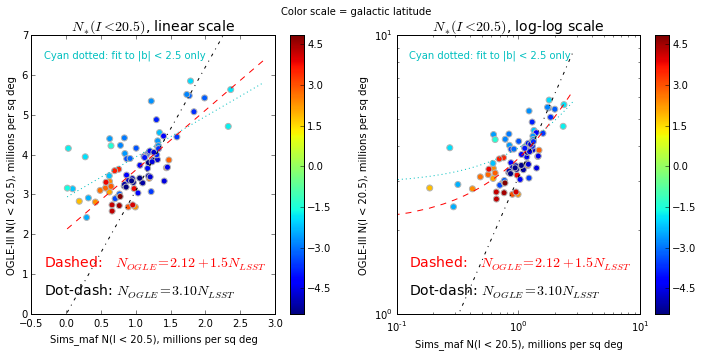

In [44]:
# Check the number density  I < 20.5

# conversion factor
sUnit = 'stars per sq arcsec'
if np.abs(cFac - 1.) > 1e-2:
    sUnit = 'millions per sq deg'
    
simSho = srcBundle.metricValues[gSims] * cFac
oglSho = tIn['N_*(I<20.5)'][gObs]

plt.figure(6, figsize=(12,5))
plt.clf()

plt.subplot(121)
plt.scatter(simSho, \
            oglSho, \
           c=tIn['b'][gObs], \
            s=36, \
           edgecolor='0.7')
plt.xlabel('Sims_maf N(I < 20.5), %s' % (sUnit))
plt.ylabel('OGLE-III N(I < 20.5), millions per sq deg')
plt.colorbar()

#dFine = np.linspace(0., 2.5, 100)
#plt.plot(dFine, 2.0 + 1.5*dFine, 'g--')

xFine2 = np.linspace(np.min(simSho)*0.8, np.max(simSho)*1.2)
yFine2 = np.polyval(parsSrcMod, xFine2)
yOutly2 = np.polyval(parsSrcOut, xFine2)


plt.plot(xFine2, yFine2, 'r--')

plt.plot(xFine2, yOutly2, color='c', ls=':')



fScal = 3.1
plt.plot(xFine2, xFine2 * fScal, 'k-.')


sAnnoBri = r'Dashed:   $N_{OGLE} = %.2f + %.1f N_{LSST}$' % (parsSrcMod[1], parsSrcMod[0])
sAnnoCon = r'Dot-dash: $N_{OGLE} = %.2f N_{LSST}$' % (fScal)
plt.annotate(sAnnoBri, \
            (0.05, 0.15), ha='left', va='bottom', color='r', fontsize=14, \
            xycoords='axes fraction')

plt.annotate(sAnnoCon, \
            (0.05, 0.05), ha='left', va='bottom', color='k', fontsize=14, \
            xycoords='axes fraction')

sOutly = 'Cyan dotted: fit to |b| < %.1f only' % (bClose)
plt.annotate(sOutly, (0.05, 0.95), \
            xycoords='axes fraction', ha='left', va='top', color='c')



plt.title(r'$N_{\ast}(I < 20.5)$, linear scale', fontsize=14)
plt.ylim(0,7)

plt.subplot(122)
ax = plt.gca()
ax.scatter(simSho, \
            oglSho, \
           c=tIn['b'][gObs], \
            s=36, \
           edgecolor='0.7')
ax.set_xscale('log')
ax.set_yscale('log')
plt.xlabel('Sims_maf N(I < 20.5), %s' % (sUnit))
plt.ylabel('OGLE-III N(I < 20.5), millions per sq deg')
plt.colorbar()

plt.plot(xFine2, yFine2, 'r--')
plt.xlim(0.1,10)
plt.ylim(1,10)
plt.title(r'$N_{\ast}(I < 20.5)$, log-log scale', fontsize=14)

plt.suptitle('Color scale = galactic latitude')

plt.plot(xFine2, xFine2 * fScal, 'k-.')
plt.plot(xFine2, yOutly2, color='c', ls=':')



plt.annotate(sAnnoBri, \
            (0.05, 0.15), ha='left', va='bottom', color='r', fontsize=14, \
            xycoords='axes fraction')

plt.annotate(sAnnoCon, \
            (0.05, 0.05), ha='left', va='bottom', color='k', fontsize=14, \
            xycoords='axes fraction')

plt.annotate(sOutly, (0.05, 0.95), \
            xycoords='axes fraction', ha='left', va='top', color='c')


As before, the cyan dotted line is the fit to "outliers" (i.e. |b| < 2.5$^{\circ}$ or so).

**Verdict:** within a factor few or so, the two densities track each other reasonably well for strongly negative galactic latitudes, but there is substantial departure at low galactic latitudes. There are two options:
* Use the linear fit to estimate $N_{OGLE}$ from $N_{LSST}$
* Use the scale factor only: $N_{OGLE} = f_{scal} N_{LSST}$

At this point my preference is to go straight for the scaling - for both $N_{lens}$ and $N_{src}$. Using the straight-line fit might impose a constant component at all sight-lines that is not present in reality.



## Use P16 from LSST densities ##

In [45]:
predBundle = mb.createEmptyMetricBundle()

In [66]:
alpha = 0.55

# Setting this to "True" seems to under-predict rates in the low-rate regions.
useScaling = False

# intermediate pieces
nRC = myBundle.metricValues * fLens
nSrc = srcBundle.metricValues * fScal * cFac

if not useScaling:
    nSrc = np.polyval(parsSrcMod, srcBundle.metricValues*cFac)
    
# P16 sensitivity
Sens = nRC**alpha * nSrc

gamma = returnGammaFromSens(Sens)

#gamma = 0.767 * Sens - 14.6

In [67]:
# swap in the metric values
predBundle.metricValues = np.copy(gamma)

(0.1, 100.0)

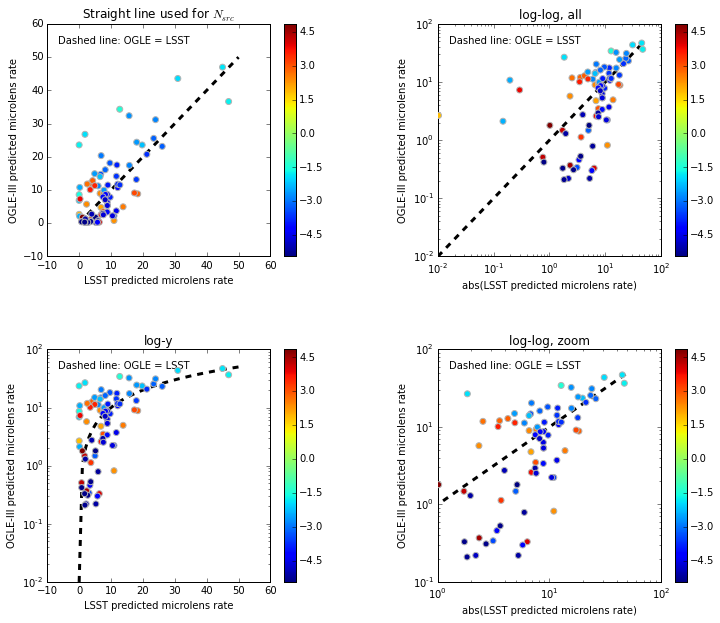

In [68]:
plt.figure(5, figsize=(12,10))
plt.clf()

lFine = np.linspace(1e-2, 50, endpoint=True)

plt.subplots_adjust(hspace=0.4, wspace=0.4)

#plt.semilogy(predBundle.metricValues[gSims], \
#            tIn['gam_0.55,20.5'][gObs], \
#            'w.', zorder=2)
plt.subplot(221)
plt.scatter(predBundle.metricValues[gSims], \
            tIn['gam_0.55,20.5'][gObs], \
           c=tIn['b'][gObs], \
            s=36, \
           edgecolor='0.7', \
            cmap=plt.cm.get_cmap('jet'), \
           zorder=15)
plt.colorbar()
plt.annotate('Dashed line: OGLE = LSST', (0.05,0.95), \
            xycoords='axes fraction', \
            ha='left', va='top', color='k')

plt.xlabel('LSST predicted microlens rate')
plt.ylabel('OGLE-III predicted microlens rate')
plt.plot(lFine, lFine, 'k--', lw=3)

if useScaling:
    plt.title(r'Scaling used for $N_{src}$')
else:
    plt.title(r'Straight line used for $N_{src}$')

###########

plt.subplot(222)
plt.loglog(lFine, lFine, 'w.', zorder=1)
plt.scatter(np.abs(predBundle.metricValues[gSims] ), \
            tIn['gam_0.55,20.5'][gObs], \
           c=tIn['b'][gObs], \
            s=36, \
           edgecolor='0.7', \
            cmap=plt.cm.get_cmap('jet'), \
           zorder=15)
plt.colorbar()
plt.annotate('Dashed line: OGLE = LSST', (0.05,0.95), \
            xycoords='axes fraction', \
            ha='left', va='top', color='k')

plt.xlabel('abs(LSST predicted microlens rate)')
plt.ylabel('OGLE-III predicted microlens rate')
plt.plot(lFine, lFine, 'k--', lw=3)
plt.title('log-log, all')

# Comment this line to see the few low-latitude outliers
plt.xlim(1e-2, 1e2)
    
###########

plt.subplot(223)
plt.semilogy(lFine, lFine, 'w.', zorder=1)
plt.scatter(predBundle.metricValues[gSims] , \
            tIn['gam_0.55,20.5'][gObs], \
           c=tIn['b'][gObs], \
            s=36, \
           edgecolor='0.7', \
            cmap=plt.cm.get_cmap('jet'), \
           zorder=15)
plt.colorbar()
plt.annotate('Dashed line: OGLE = LSST', (0.05,0.95), \
            xycoords='axes fraction', \
            ha='left', va='top', color='k')

plt.xlabel('LSST predicted microlens rate')
plt.ylabel('OGLE-III predicted microlens rate')
plt.plot(lFine, lFine, 'k--', lw=3)
plt.title('log-y')

###########

plt.subplot(224)
plt.loglog(lFine, lFine, 'w.', zorder=1)
plt.scatter(np.abs(predBundle.metricValues[gSims] ), \
            tIn['gam_0.55,20.5'][gObs], \
           c=tIn['b'][gObs], \
            s=36, \
           edgecolor='0.7', \
            cmap=plt.cm.get_cmap('jet'), \
           zorder=15)
plt.colorbar()
plt.annotate('Dashed line: OGLE = LSST', (0.05,0.95), \
            xycoords='axes fraction', \
            ha='left', va='top', color='k')

plt.xlabel('abs(LSST predicted microlens rate)')
plt.ylabel('OGLE-III predicted microlens rate')
plt.plot(lFine, lFine, 'k--', lw=3)
plt.title('log-log, zoom')
plt.xlim(1., 100.)
plt.ylim(0.1, 100.)

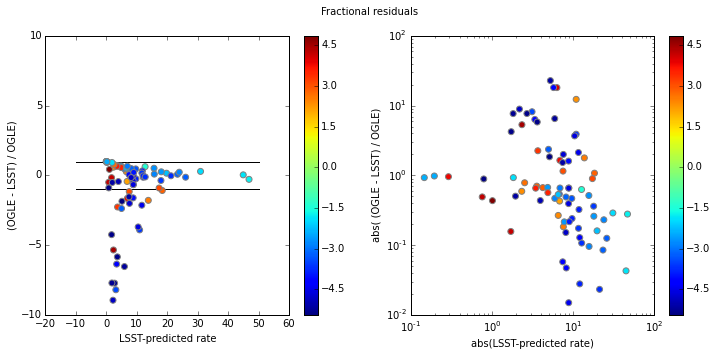

In [69]:
# plot residuals
resids = tIn['gam_0.55,20.5'][gObs] - predBundle.metricValues[gSims] 
plt.figure(7, figsize=(12,5))
plt.clf()
plt.subplot(122)
plt.loglog(predBundle.metricValues[gSims], \
             np.abs(resids/tIn['gam_0.55,20.5'][gObs]), \
            'w.', zorder=1)

plt.scatter(np.abs(predBundle.metricValues[gSims]), \
             np.abs(resids/tIn['gam_0.55,20.5'][gObs]), \
            c=tIn['b'][gObs], \
            zorder=15, \
           s=36, edgecolor='0.5')
plt.xlim(0.1, 100)
plt.colorbar()
plt.xlabel('abs(LSST-predicted rate)')
plt.ylabel('abs( (OGLE - LSST) / OGLE)')

plt.subplot(121)
plt.plot(predBundle.metricValues[gSims], \
             resids/tIn['gam_0.55,20.5'][gObs], \
            'w.', zorder=1)

plt.scatter(predBundle.metricValues[gSims], \
             resids/tIn['gam_0.55,20.5'][gObs], \
            c=tIn['b'][gObs], \
            zorder=15, \
           s=36, edgecolor='0.5')
plt.ylim(-10,10)
plt.colorbar()
plt.xlabel('LSST-predicted rate')
plt.ylabel('(OGLE - LSST) / OGLE)')

xLims = np.copy(plt.xlim())
plt.plot(xLims, [1., 1.], 'k-')
plt.plot(xLims, [-1., -1.], 'k-')


plt.suptitle('Fractional residuals')
